In [1]:
%matplotlib inline
import os
import cv2
import pickle
#import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from TileHandler import *
from data_utils import *

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
X=np.load('./X.npy')

In [3]:
X.shape

(50000, 96, 96, 1)

In [4]:
tile_size=96
channels=1
input_shape = (tile_size, tile_size, channels)

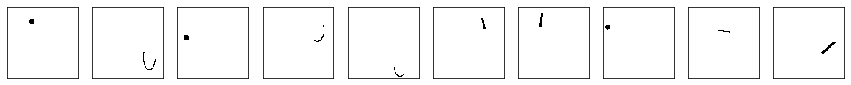

In [5]:
#部分显示图片
n = 10 # how many digits we will display
plt.figure(figsize=(15, 15))
for i in range(n):
    # display original
    #ax = plt.subplot(2, n, i + 1)
    ax=plt.subplot(1, 10, i+1)
    plt.imshow(X[i].reshape(tile_size, tile_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [6]:
AE_model = load_model("tile-autoencoder-model.h5")

In [7]:
AE_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 8)         584       
__________

In [8]:
img_decoded = AE_model.predict(X[:5])

Before autoencoding:


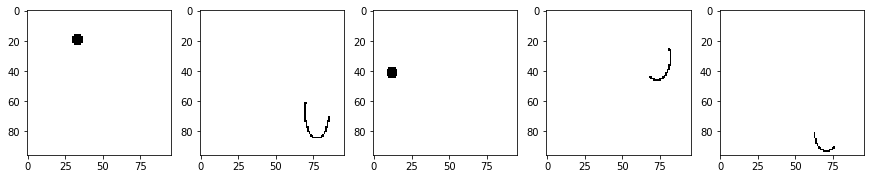

After decoding:


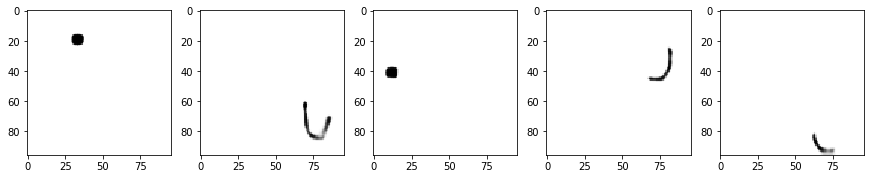

In [9]:
# 检查 autoencoder 的效果
def plot_some(im_list):
    plt.figure(figsize=(15,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(array.reshape(tile_size,tile_size))
        #plt.axis('off')
    plt.show()

img_decoded = AE_model.predict(X[:5])

print('Before autoencoding:')
plot_some(X[:5])
print('After decoding:')
plot_some(img_decoded)

In [10]:
# 取 100 个样本来做下分析
X_sample = X[:100]
print(X_sample.shape)

(100, 96, 96, 1)


In [11]:
# 创建一个获取图片 encoded 结果的函数, 即取模型的 encoder 部分 (前六层)
# Keras 如何获取中间层, 参考官方文档:
# https://keras.io/zh/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
get_encoded = K.function([AE_model.layers[0].input], [AE_model.layers[5].output])

# 获取样本的 encoded 结果
encoded_sample = get_encoded([X_sample])[0]

print(encoded_sample.shape)

(100, 12, 12, 8)


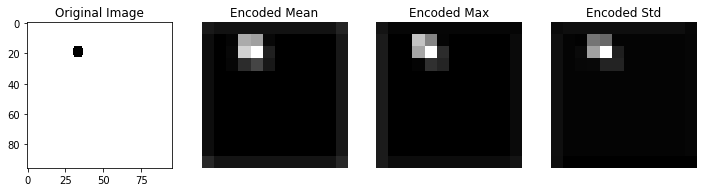

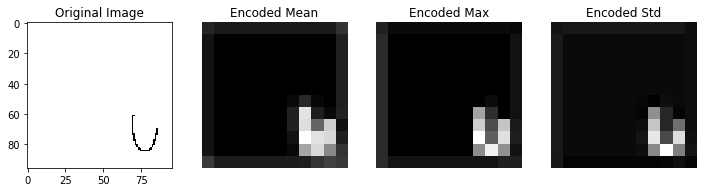

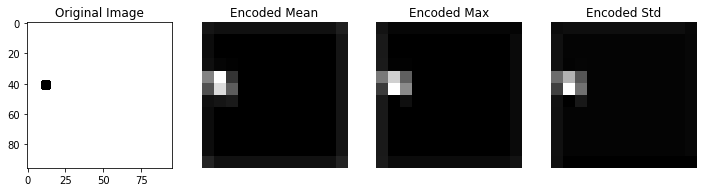

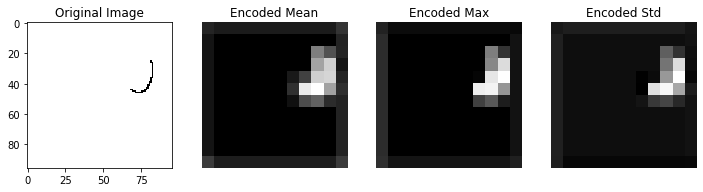

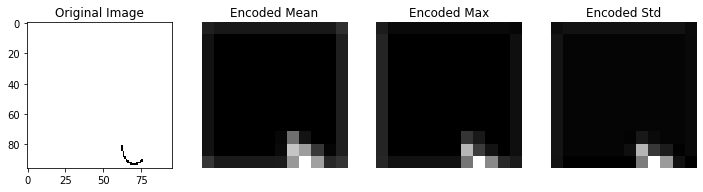

In [12]:
# 看下 encode 之后的图片是什么情况
# 因为 shape 是 16*16*8, 因此需要转成灰度才能将图片显示出来, 分别将最后的维度用 mean, max, std 来取值
# 从结果来看, 部分图片隐约还能看到个轮廓

for n_image in range(0, 5):
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(X_sample[n_image].reshape(tile_size,tile_size))
    #plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=-1))
    plt.axis('off')
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=-1))
    plt.axis('off')
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=-1))
    plt.axis('off')
    plt.title('Encoded Std')

    plt.show()

In [13]:
# 所有图片 encoded 之后的数据

X_encoded = np.empty((len(X), 12, 12, 8), dtype='float32')

step = 100
for i in range(0, len(X), step):
    x_batch = get_encoded([X[i:i+step]])[0]
    X_encoded[i:i+step] = x_batch

print(X_encoded.shape)

(50000, 12, 12, 8)


In [14]:
# reshape, 其实相当于 flatten, 之后给 KMeans 用

X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print(X_encoded_reshape.shape)

(50000, 1152)


In [2]:
plt.imshow(X_encoded_reshape[1].max(axis=-1))

NameError: name 'plt' is not defined

In [15]:
# KMeans 聚类
n_clusters = 100
km = KMeans(n_clusters=n_clusters)
km.fit(X_encoded_reshape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<BarContainer object of 100 artists>

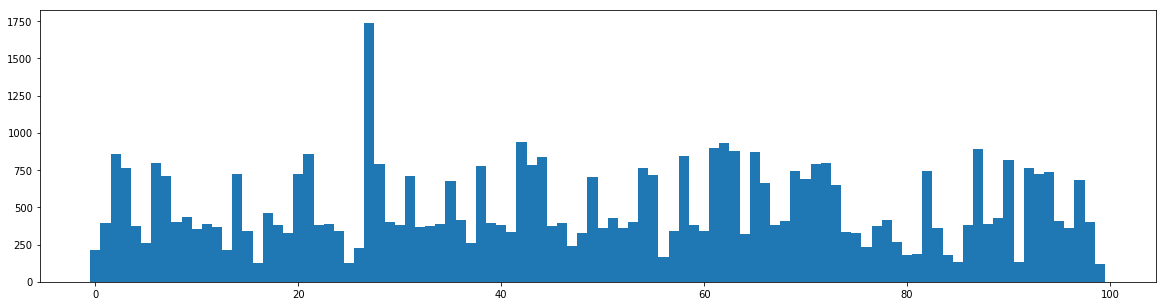

In [16]:
# 看下 clusters 的分布结果

plt.figure(figsize=(20,5))
cluster_elements = [(km.labels_==i).sum() for i in range(n_clusters)]
plt.bar(range(n_clusters), cluster_elements, width=1)

In [17]:
# 每个聚类的 encoded 均值

average_clusters_encoded = []
for i in range(n_clusters):
    average_clusters_encoded.append(X_encoded[km.labels_==i].mean(axis=0))

average_clusters_encoded = np.asarray(average_clusters_encoded)

print(average_clusters_encoded.shape)

(100, 12, 12, 8)


In [18]:
#取出模型的 decoder 部分

get_decoded = K.function([AE_model.layers[6].input],
                         [AE_model.layers[-1].output])

# "平均" decoded 图像
decoded_clusters = get_decoded([average_clusters_encoded])

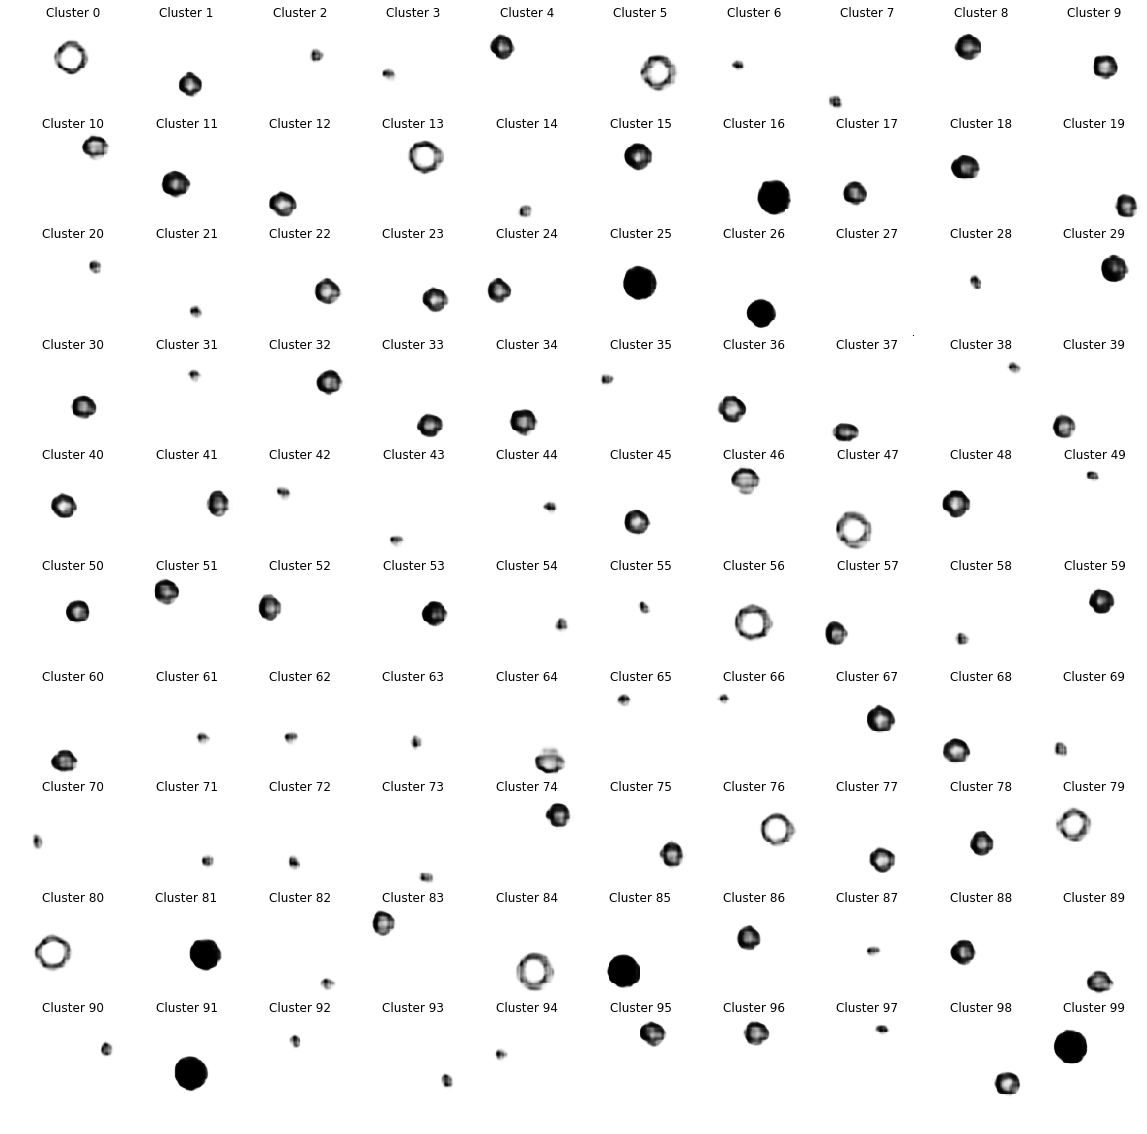

In [19]:
# 打印出所有聚类的" 平均" decoded 图像

plt.figure(figsize=(20,20))

for i in range(n_clusters):
    plt.subplot(10, 10, i+1)
    plt.imshow(decoded_clusters[0][i].reshape(tile_size,tile_size))
    plt.title('Cluster {}'.format(i))
    plt.axis('off')

plt.show()

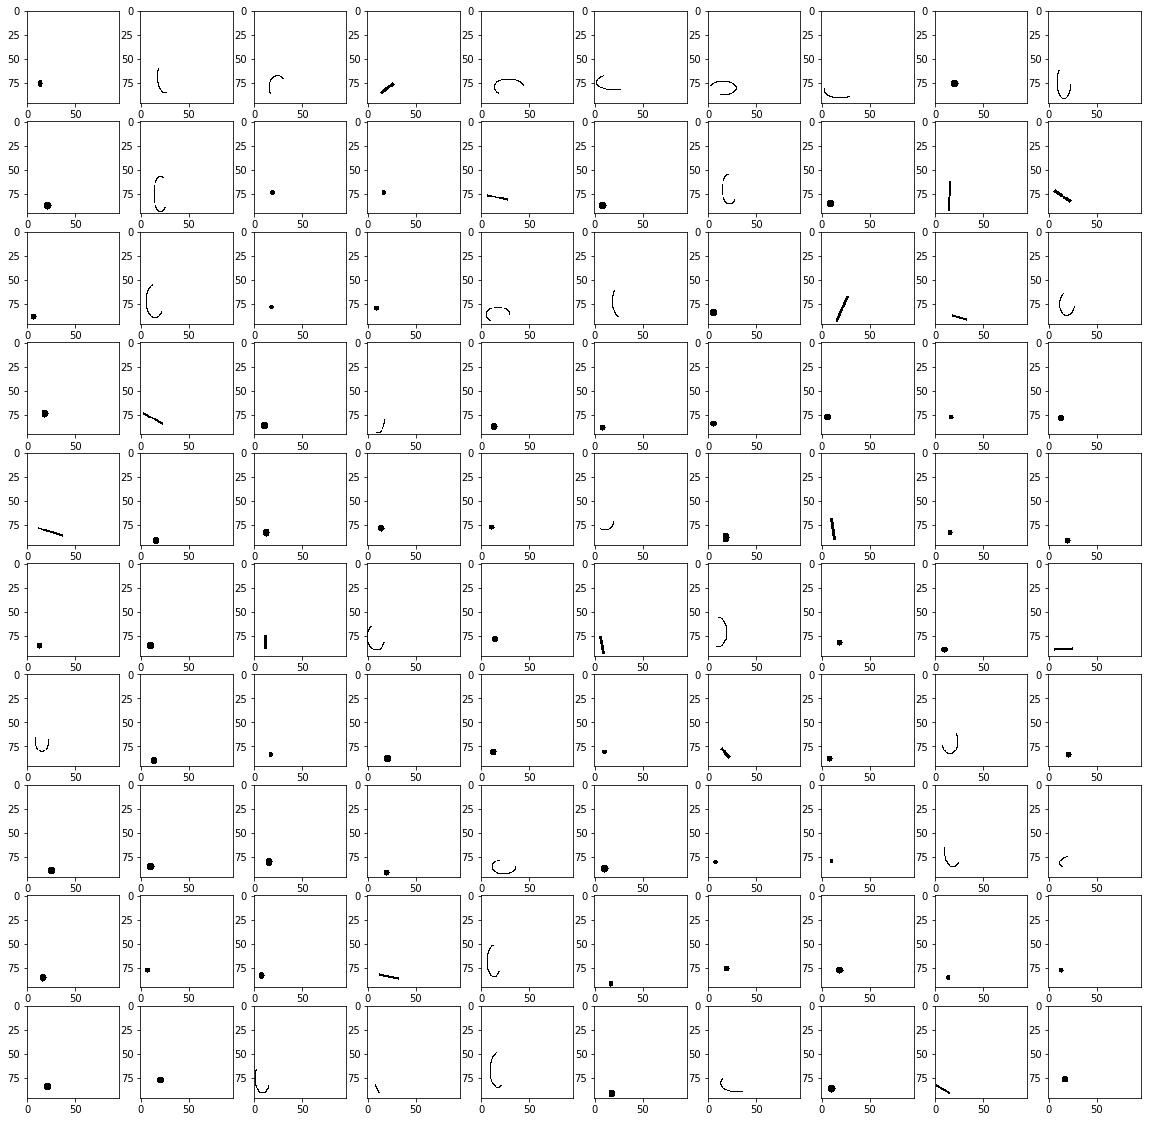

In [32]:
# 从上面可以看到有比较明显的聚类效果


plt.figure(figsize=(20, 20))

cluster =7
rows, cols = 10, 10
start = 0

labels = np.where(km.labels_==cluster)[0][start:start+rows*cols]
for i, label in enumerate(labels):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X[label].reshape(tile_size,tile_size))
    #plt.axis('off')

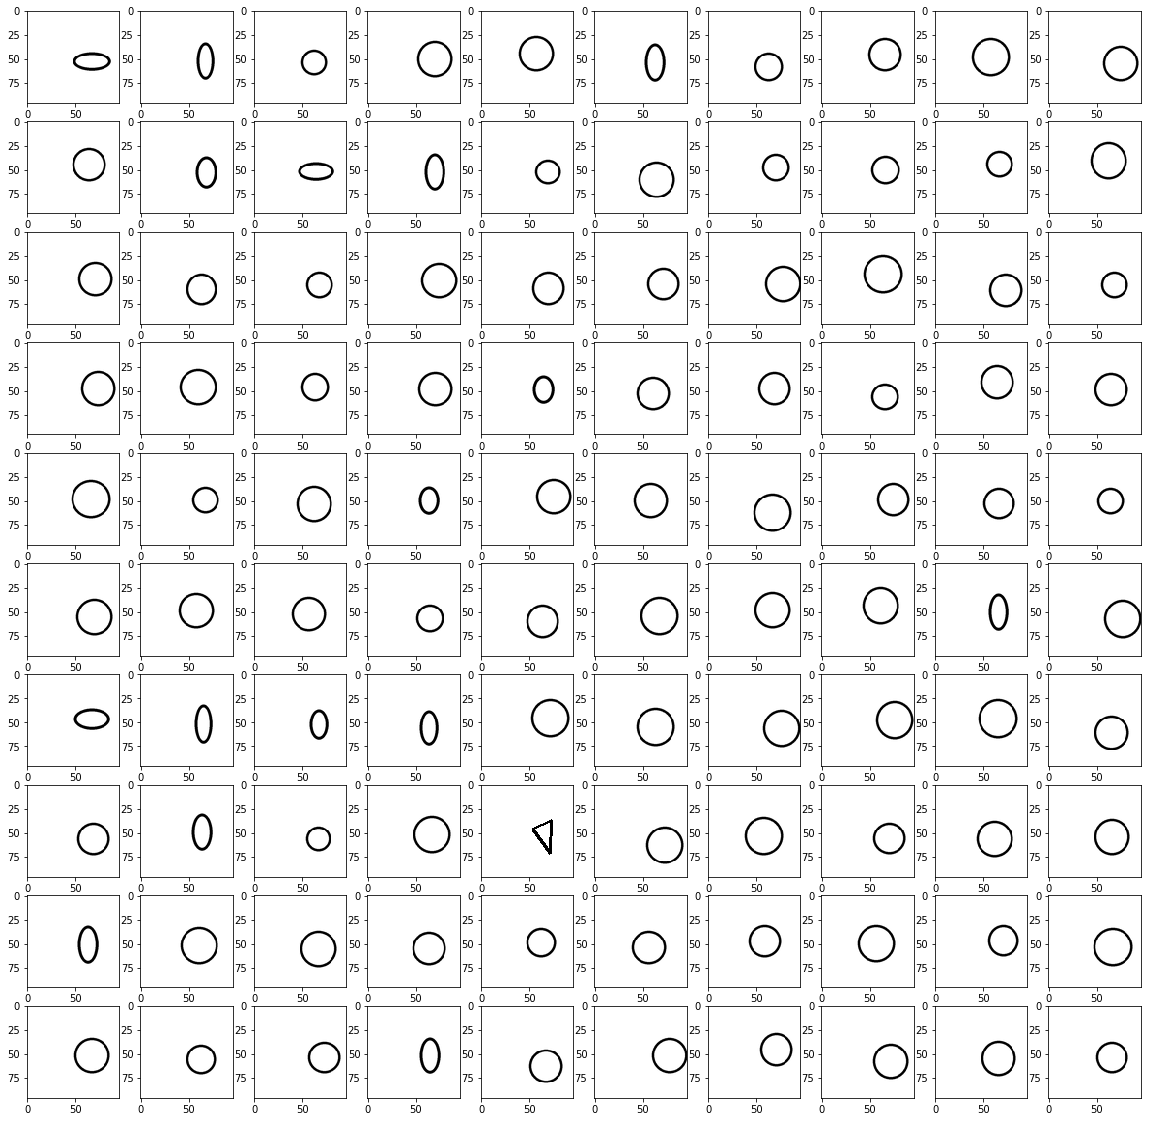

In [30]:
# 从上面可以看到有比较明显的聚类效果


plt.figure(figsize=(20, 20))

cluster =5

rows, cols = 10, 10
start = 0

labels = np.where(km.labels_==cluster)[0][start:start+rows*cols]
for i, label in enumerate(labels):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X[label].reshape(tile_size,tile_size))
    #plt.axis('off')

In [22]:
# 保存分类结果

pickle.dump(km, open('km_encoded.sav', 'wb'))

In [25]:
# autoencoder 各层输出

get_1st_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[0].output])
get_2nd_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[1].output])
get_3rd_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[2].output])
get_4th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[3].output])
get_5th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[4].output])
get_6th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[5].output])
get_7th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[6].output])
get_8th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[7].output])
get_9th_layer  = K.function([AE_model.layers[0].input], [AE_model.layers[8].output])
get_10th_layer = K.function([AE_model.layers[0].input], [AE_model.layers[9].output])
get_11th_layer = K.function([AE_model.layers[0].input], [AE_model.layers[10].output])

sample_layer_1  = get_1st_layer([X_sample])[0]
sample_layer_2  = get_2nd_layer([X_sample])[0]
sample_layer_3  = get_3rd_layer([X_sample])[0]
sample_layer_4  = get_4th_layer([X_sample])[0]
sample_layer_5  = get_5th_layer([X_sample])[0]
sample_layer_6  = get_6th_layer([X_sample])[0]
sample_layer_7  = get_7th_layer([X_sample])[0]
sample_layer_8  = get_8th_layer([X_sample])[0]
sample_layer_9  = get_9th_layer([X_sample])[0]
sample_layer_10 = get_10th_layer([X_sample])[0]
sample_layer_11 = get_11th_layer([X_sample])[0]
img_decoded = AE_model.predict(X_sample)

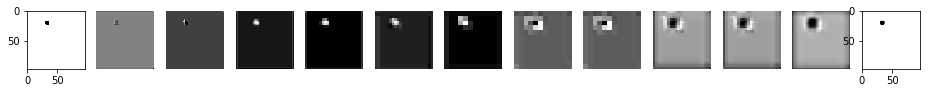

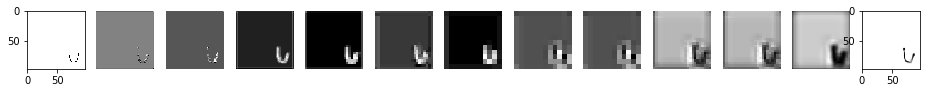

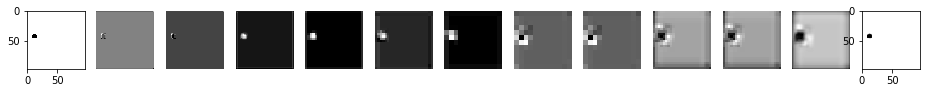

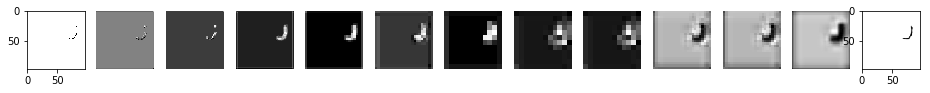

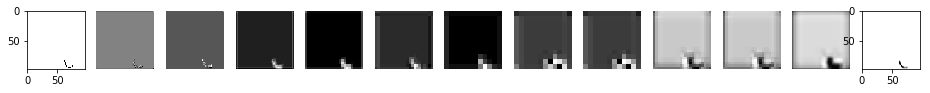

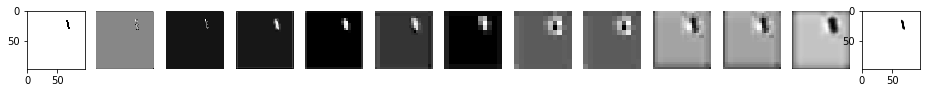

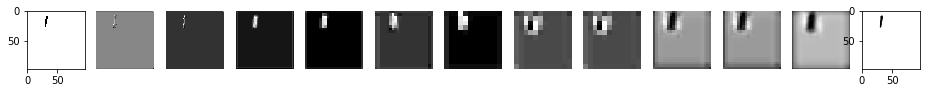

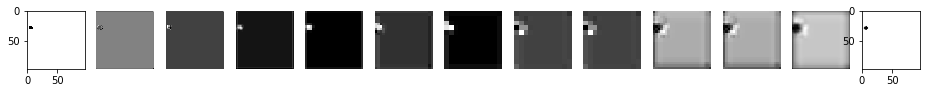

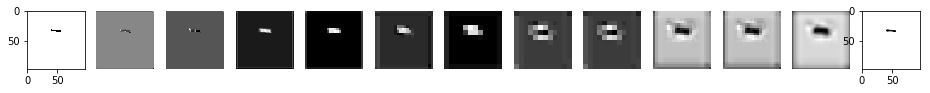

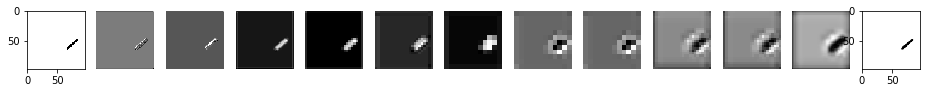

In [26]:
# 打印出中间层图片

for n_image in range(0, 10):
    
    plt.figure(figsize=(16,8))

    plt.subplot(1,13,1)
    plt.imshow(X_sample[n_image].max(axis=-1))
   # plt.axis('off')

    plt.subplot(1,13,2)
    plt.imshow(sample_layer_1[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,3)
    plt.imshow(sample_layer_2[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,4)
    plt.imshow(sample_layer_3[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,5)
    plt.imshow(sample_layer_4[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,6)
    plt.imshow(sample_layer_5[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,7)
    plt.imshow(sample_layer_6[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,8)
    plt.imshow(sample_layer_7[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,9)
    plt.imshow(sample_layer_8[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,10)
    plt.imshow(sample_layer_9[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,11)
    plt.imshow(sample_layer_10[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,12)
    plt.imshow(sample_layer_11[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,13)
    plt.imshow(img_decoded[n_image].max(axis=-1))
   # plt.axis('off')
    
    plt.show()